https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

https://catboost.ai/en/docs/references/training-parameters/

In [1]:
import pandas as pd
from funciones import CargarPandasDatasetCategoricos, CargarPandasDataset, BorrarColumnas, obtenerOhe

In [47]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
from sklearn import tree #La versión que tengo es 0.24.1 y está disponible apartir de la 0.21
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shap


# Preprocesado y modelado
# ==============================================================================
import sklearn
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.experimental import enable_hist_gradient_boosting # enable experimental features first in order to import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier, Pool

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [3]:
endireh = CargarPandasDataset('datasets/endireh.csv')

In [4]:
endireh.shape

(23669, 49)

## Preprocesamiento


Solo nos quedamos con las que sufieron violencia

In [5]:
endireh.drop(endireh[endireh["P9_8"]==0].index, axis=0, inplace=True)

In [6]:
endireh.shape

(6771, 49)

In [ ]:
endireh["P9_8"] = endireh["P9_8"]-1

Obtengo la variable objetivo _y_.

In [7]:
y = endireh['P9_8'].copy()

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [8]:
endireh.drop(columns=['P9_8', 'REGION'], inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(endireh, y, test_size=0.33, random_state=42)

Abuso y violencia(0):	52%
Ambos(2):	26%
Atencion no autorizada(1):	22%


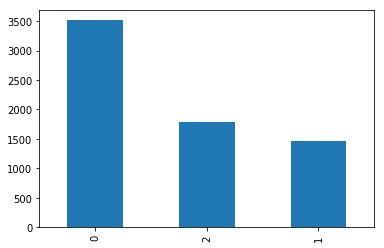

In [57]:
for i,j in zip(['Abuso y violencia(0)', 'Ambos(2)', 'Atencion no autorizada(1)'], y.value_counts()/y.value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
y.value_counts().plot(kind='bar')

## sklearn.ensemble.HistGradientBoostingClassifier

## CatBoost.CatBoostClassifier

In [37]:
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='MultiClass',
                           custom_metric="F1",
                           use_best_model=False,
                           verbose=0)

In [38]:
# train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))

In [39]:
# make the prediction using the resulting model
preds_class = model.predict(X_test)

In [40]:
f1_score(y_test, preds_class, average='micro')

0.5337807606263982

In [41]:
f1_score(y_test, preds_class, average='macro')

0.27180019793896576

In [42]:
categorical_features_indices = np.where(endireh.dtypes == np.object)[0]

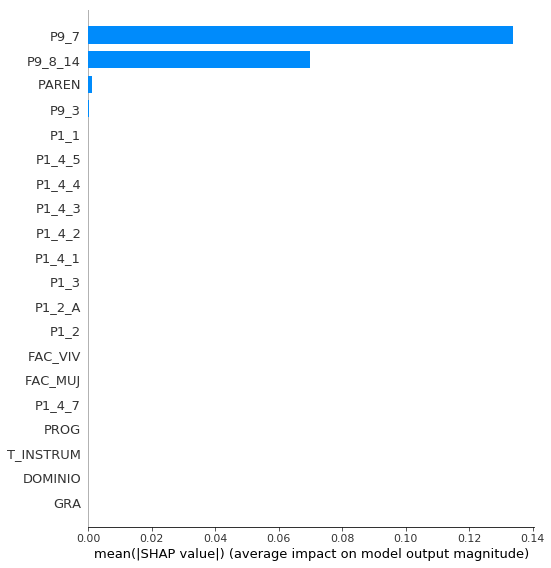

In [43]:
shap_values = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
) 
shap_values = shap_values[:, 0, :-1] 
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [44]:
model.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_features_indices))

array([ 0.        ,  0.        ,  1.35736691,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.07311144,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 32.22474691,  0.        ,
        0.        , 66.34477473])

F1 por clase

devuelve precision, recall, f1 y ocurrencias

In [56]:
precision_recall_fscore_support(y_test, preds_class)

(array([0.53432282, 0.        , 0.51898734]),
 array([0.98799314, 0.        , 0.06902357]),
 array([0.6935581, 0.       , 0.1218425]),
 array([1166,  475,  594]))

## Encontrar los mejores parámetros con _Grid Search_

Declaramos los parametros

To check:
1. fold_permutation_block
2. output_borders
3. auto_class_weights, and
4. feature_weights

In [63]:
param_grid = ParameterGrid(
                    {
                     'grow_policy'        : ['Depthwise', 'SymmetricTree', 'Lossguide'], # The tree growing policy. 
                     'depth'              : range(4, 17, 2), # max_depth
                     'learning_rate'      : [i/100 for i in range(85,95)], # eta
                     'iterations'         : [100],
                     'min_data_in_leaf'   : range(100, 151, 3), # min_samples_split
                    }
                )

len(param_grid)

3570

Creamos el diccionario que guadará los resultados

In [68]:
resultados = {'params': [], 'f1': [], 'f1_violencia':[], 'f1_atencion':[], 'f1_ambos':[]}
importances = []

### Loop para ajustar un modelo con cada combinación de hiperparámetros

In [65]:
categorical_features_indices = np.where(endireh.dtypes == np.object)[0]

In [81]:
%%time
print(f'Creando modelos para {len(param_grid)} combinaciones de parámetros.\n')

for i,params in enumerate(list(param_grid)):
    if i >= 3231:
        model = CatBoostClassifier(
                               loss_function          = 'MultiClass',
                               custom_metric          = "F1",
                               leaf_estimation_method = "Gradient", # The method used to calculate the values in leaves.
                               boosting_type          = 'Plain',
                               verbose                = 0,
                               use_best_model         = True,
                               random_seed            = 5,
                               ** params
                    )

        X_train, X_test, y_train, y_test = train_test_split(endireh, y, test_size=0.33)

        # train the model if use_best_model=False
        #model.fit(X=X_train, y=y_train)

        # train the model if use_best_model=True
        model.fit(X=X_train, y=y_train, eval_set=(X_test, y_test))

        resultados['params'].append(params)
        resultados['f1'].append(f1_score(y_test, model.predict(X_test), average='micro'))
        f1 = precision_recall_fscore_support(y_test, preds_class)[2]
        resultados['f1_violencia'].append(f1[0])
        resultados['f1_atencion'].append(f1[1])
        resultados['f1_ambos'].append(f1[2])

        importances.append(model.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_features_indices)))

        if i%450 == 0 or i==len(param_grid):
            print(f"Modelo {i}: {params} \u2713 ({resultados['f1'][-1]})")

print('\n')

Creando modelos para 3570 combinaciones de parámetros.



Custom logger is already specified. Specify more than one logger at same time is not thread safe.



CPU times: user 1d 8h 57min 54s, sys: 14h 4min 42s, total: 1d 23h 2min 36s
Wall time: 10h 17min 13s


In [82]:
len(importances)

3570

## Visualizamos resultados

### A. 15 de enero de 2022 20160 combinaciones

    param_grid = ParameterGrid(
                    {
                     'iterations'       : range(90,150, 15),  # n_estimators same default as in sklearn RFC
                     'learning_rate'    : [i/100 for i in range(85,100, 2)], # eta
                     'random_seed'      : [42, 666, 5],
                     'grow_policy'      : ['Depthwise'], # The tree growing policy. 
                     'random_strength'  : [1+(i/10) for i in range(1,6)], # The amount of randomness to use for scoring splits
                     'depth'            : [9, 12, 16], # max_depth
                     'min_data_in_leaf' : range(90, 151, 10), # min_samples_split
                     'langevin'         : [True, False]
                    }
                )
                
Puesto a las 18:09 horas. Sin experiencia previa. Terminó 23:30 hrs. Duró 6:30 hrs.

In [98]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('f1', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,f1,depth,iterations,langevin,learning_rate,min_data_in_leaf,random_seed,random_strength
16736,0.489038,16,105,False,0.99,110,5,1.1
15181,0.477852,16,105,True,0.85,130,42,1.1
6303,0.477405,9,135,False,0.93,90,42,1.3
13050,0.476957,12,135,False,0.93,100,5,1.5
11239,0.476957,12,120,False,0.91,90,42,1.4
18603,0.476510,16,135,True,0.87,100,42,1.3
14151,0.475168,16,90,True,0.97,140,666,1.1
11787,0.474720,12,135,True,0.85,100,5,1.2
11181,0.474273,12,120,False,0.89,120,666,1.1
10979,0.474273,12,120,False,0.85,120,5,1.4


In [105]:
textfile = open("FI/feature_importance_GBM_A.txt", "w")
for element in importances[16736]:
    textfile.write(str(element) + "\n")
textfile.close()

### B. 23 de enero de 2022 41472 combinaciones

    param_grid = ParameterGrid(
                    {
                     'auto_class_weights' : [None, 'Balanced', 'SqrtBalanced'],
                     'grow_policy'        : ['Depthwise', 'SymmetricTree', 'Lossguide'], # The tree growing policy. 
                     'depth'              : range(5, 17, 2), # max_depth
                     'learning_rate'      : [i/100 for i in range(84,101, 2)], # eta
                     'iterations'         : range(90,150, 15),  # n_estimators same default as in sklearn RFC
                     'min_data_in_leaf'   : range(1, 151, 20), # min_samples_split
                    }
                )

Puesto a las 17:33 horas. Debería durar 6 hrs.

In [21]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('f1', ascending=False)
resultados = resultados.drop(columns = 'params')

In [36]:
resultados.head(15)

,f1,depth,grow_policy,iterations,langevin,learning_rate,min_data_in_leaf,random_seed
1775,0.532886,2,Lossguide,90,True,0.86,141,5
938,0.528859,2,SymmetricTree,90,True,0.90,1,5
1187,0.528412,2,SymmetricTree,105,True,0.92,61,5
2255,0.527069,2,Lossguide,120,True,0.90,141,5
2182,0.527069,2,Lossguide,120,True,0.84,141,666
2160,0.525280,2,Lossguide,120,True,0.84,1,42
1184,0.525280,2,SymmetricTree,105,True,0.92,41,5
1695,0.524832,2,SymmetricTree,135,True,0.98,101,42
1238,0.524832,2,SymmetricTree,105,True,0.96,81,5
160,0.524385,2,Depthwise,90,True,0.96,101,666


In [ ]:
textfile = open("FI/feature_importance_GBM_B1.txt", "w")
for element in importances[4050]:
    textfile.write(str(element) + "\n")
textfile.close()

In [26]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('f1', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(15)

,f1,auto_class_weights,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
2535,0.553915,None,9,Lossguide,135,0.86,141
510,0.553468,None,5,SymmetricTree,135,0.84,121
5040,0.553020,None,15,Lossguide,120,0.84,1
516,0.552573,None,5,SymmetricTree,135,0.86,81
267,0.551678,None,5,Depthwise,135,0.96,61
1513,0.551678,None,7,Lossguide,105,0.84,21
143,0.551230,None,5,Depthwise,105,1.00,141
3332,0.550783,None,11,Lossguide,120,0.88,81
4175,0.550783,None,13,Lossguide,105,1.00,141
214,0.550783,None,5,Depthwise,120,1.00,121


In [27]:
textfile = open("FI/feature_importance_GBM_B2.txt", "w")
for element in importances[list(resultados.index)[0]]:
    textfile.write(str(element) + "\n")
textfile.close()

In [47]:
resultados1 = pd.DataFrame(resultados)
resultados1 = pd.concat([resultados1, resultados1['params'].apply(pd.Series)], axis=1)
resultados1 = resultados1.drop(columns = 'params')

In [52]:
resultados1 = resultados1.sort_values('f1', ascending=False)
resultados1.head(15)

,f1,auto_class_weights,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
3440,0.541387,Balanced,11,Lossguide,135,0.98,1
159,0.536018,Balanced,15,Lossguide,105,0.86,1
3272,0.535570,Balanced,11,Lossguide,105,0.92,1
3288,0.534676,Balanced,11,Lossguide,105,0.96,1
143,0.534228,Balanced,15,Lossguide,90,1.00,1
4312,0.534228,Balanced,13,Lossguide,135,1.00,1
2544,0.531096,Balanced,9,Lossguide,135,0.90,1
1664,0.531096,Balanced,7,Lossguide,135,0.86,1
4272,0.531096,Balanced,13,Lossguide,135,0.90,1
4144,0.530201,Balanced,13,Lossguide,105,0.94,1


In [43]:
textfile = open("FI/feature_importance_GBM_B3.txt", "w")
for element in importances[list(resultados.index)[0]]:
    textfile.write(str(element) + "\n")
textfile.close()

### C. 25 de enero de 2022 9408 combinaciones

    param_grid = ParameterGrid(
                    {
                     'auto_class_weights' : [None, 'Balanced'],
                     'grow_policy'        : ['Depthwise', 'SymmetricTree', 'Lossguide'], # The tree growing policy. 
                     'depth'              : range(4, 17, 2), # max_depth
                     'learning_rate'      : [i/100 for i in range(85,100, 2)], # eta
                     'iterations'         : range(90,151, 10),  # n_estimators same default as in sklearn RFC
                     'min_data_in_leaf'   : range(100, 151, 15), # min_samples_split
                    }
                )

Puesto a las 23:18 horas.

In [24]:
resultados1 = pd.DataFrame(resultados)
resultados1 = pd.concat([resultados1, resultados1['params'].apply(pd.Series)], axis=1)
resultados1 = resultados1.drop(columns = 'params')

In [25]:
resultados1 = resultados1.sort_values('f1', ascending=False)
resultados1.head(15)

,f1,auto_class_weights,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
1289,0.555257,None,6,Lossguide,140,0.89,115
3330,0.554362,None,12,Lossguide,150,0.85,130
1383,0.553020,None,8,Depthwise,100,0.87,145
171,0.552573,None,4,Depthwise,140,0.89,145
1004,0.551230,None,6,SymmetricTree,120,0.91,100
592,0.551230,None,4,Lossguide,130,0.93,100
645,0.550336,None,4,Lossguide,150,0.87,115
674,0.550336,None,6,Depthwise,90,0.85,130
3907,0.548993,None,14,Lossguide,120,0.85,145
1855,0.548546,None,8,Lossguide,100,0.99,145


In [26]:
textfile = open("FI/feature_importance_GBM_C1.txt", "w")
for element in importances[list(resultados1.index)[0]]:
    textfile.write(str(element) + "\n")
textfile.close()

### D. 30 de enero de 2022 9408 combinaciones

    param_grid = ParameterGrid(
                    {
                     'grow_policy'        : ['Depthwise', 'SymmetricTree', 'Lossguide'], # The tree growing policy. 
                     'depth'              : range(4, 17, 2), # max_depth
                     'learning_rate'      : [i/100 for i in range(85,95)], # eta
                     'iterations'         : [100],
                     'min_data_in_leaf'   : range(100, 151, 3), # min_samples_split
                    }
                )

Puesto 9:40 am.

In [31]:
resultados1 = pd.DataFrame(resultados)
resultados1 = pd.concat([resultados1, resultados1['params'].apply(pd.Series)], axis=1)
resultados1 = resultados1.drop(columns = 'params')

In [33]:
resultados1 = resultados1.sort_values('f1', ascending=False)
resultados1.head(15)

,f1,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
2932,0.556600,14,Lossguide,100,0.87,124
930,0.556152,6,Lossguide,100,0.89,136
325,0.553915,4,SymmetricTree,100,0.94,106
1298,0.551678,8,SymmetricTree,100,0.91,118
1191,0.551230,8,SymmetricTree,100,0.85,103
398,0.550336,4,Lossguide,100,0.88,121
2399,0.549888,12,Lossguide,100,0.86,106
106,0.549441,4,Depthwise,100,0.91,112
1339,0.549441,8,SymmetricTree,100,0.93,139
707,0.548993,6,SymmetricTree,100,0.86,130


In [32]:
textfile = open("FI/feature_importance_GBM_D1.txt", "w")
for element in importances[list(resultados1.index)[0]]:
    textfile.write(str(element) + "\n")
textfile.close()

### E. 31 de enero de 2022 9408 combinaciones

    param_grid = ParameterGrid(
                    {
                     'grow_policy'        : ['Depthwise', 'SymmetricTree', 'Lossguide'], # The tree growing policy. 
                     'depth'              : range(4, 17, 2), # max_depth
                     'learning_rate'      : [i/100 for i in range(85,95)], # eta
                     'iterations'         : [100],
                     'min_data_in_leaf'   : range(100, 151, 3), # min_samples_split
                    }
                )

Puesto 15:41 pm.

In [83]:
resultados1 = pd.DataFrame(resultados)
resultados1 = pd.concat([resultados1, resultados1['params'].apply(pd.Series)], axis=1)
resultados1 = resultados1.drop(columns = 'params')

In [93]:
resultados1.sort_values('f1', ascending=False).head(8)

,f1,f1_violencia,f1_atencion,f1_ambos,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
1300,0.552573,0.697150,0.0,0.064417,8,SymmetricTree,100,0.91,124
3426,0.551230,0.687909,0.0,0.062598,16,Lossguide,100,0.86,127
795,0.550783,0.693063,0.0,0.065319,6,SymmetricTree,100,0.91,139
2465,0.549888,0.693683,0.0,0.077399,12,Lossguide,100,0.90,100
123,0.549441,0.691006,0.0,0.047923,4,Depthwise,100,0.92,112
230,0.548993,0.689326,0.0,0.051988,4,SymmetricTree,100,0.88,127
3404,0.548993,0.688134,0.0,0.070175,16,Lossguide,100,0.85,112
937,0.548993,0.690149,0.0,0.059524,6,Lossguide,100,0.90,106


In [95]:
resultados1.sort_values('f1_ambos', ascending=False).head(8)

,f1,f1_violencia,f1_atencion,f1_ambos,depth,grow_policy,iterations,learning_rate,min_data_in_leaf
365,0.522148,0.682573,0.0,0.105109,4,Lossguide,100,0.86,124
1131,0.540045,0.690604,0.0,0.100152,8,Depthwise,100,0.91,127
2949,0.507383,0.669912,0.0,0.098694,14,Lossguide,100,0.88,124
1161,0.529306,0.682473,0.0,0.097027,8,Depthwise,100,0.93,115
846,0.533781,0.685252,0.0,0.096823,6,SymmetricTree,100,0.94,139
2003,0.514094,0.666260,0.0,0.096774,10,Lossguide,100,0.92,142
1770,0.510515,0.675937,0.0,0.096350,10,SymmetricTree,100,0.89,106
573,0.530201,0.676524,0.0,0.095665,6,Depthwise,100,0.88,136


In [97]:
resultados1[['f1', 'f1_violencia', 'f1_atencion','f1_ambos']].describe()

,f1,f1_violencia,f1_atencion,f1_ambos
count,3570.000000,3570.000000,3570.0,3570.000000
mean,0.515011,0.674719,0.0,0.062548
std,0.020704,0.007807,0.0,0.011504
min,0.421924,0.643232,0.0,0.017621
25%,0.509172,0.669494,0.0,0.054795
50%,0.520358,0.674721,0.0,0.062402
75%,0.528412,0.679880,0.0,0.069909
max,0.552573,0.704942,0.0,0.105109


In [85]:
textfile = open("FI/feature_importance_GBM_E1.txt", "w")
for element in importances[list(resultados1.index)[0]]:
    textfile.write(str(element) + "\n")
textfile.close()